In [1]:
%reload_ext tensorboard
%reload_ext autoreload

# Energy Based Model

In [2]:
import os
import time
import math
import torch
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.distributions as tdist

from joblib import dump, load
from sklearn.decomposition import PCA
from pdmtut.core import GenerativeModel
from pytorch_lightning import loggers as pl_loggers

In [3]:
store_results = True
load_models = True

## Introduction

## Implementation

In [4]:
class EnergyBasedModel(pl.LightningModule, GenerativeModel):
    class Decoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.dec1 = nn.Linear(2, 64)
            self.decbn1 = nn.BatchNorm1d(num_features=64)
            self.dec2 = nn.Linear(64, 128)
            self.decbn2 = nn.BatchNorm1d(num_features=128)
            self.dec3 = nn.Linear(128, 128)
            self.decbn3 = nn.BatchNorm1d(num_features=128)
            self.dec4 = nn.Linear(128, 64)
            self.dec5 = nn.Linear(64, 3)

        def forward(self, z):
            x = F.elu(self.decbn1(self.dec1(z)))
            x = F.elu(self.decbn2(self.dec2(x)))
            x = F.elu(self.decbn3(self.dec3(x)))
            x = F.elu(self.dec4(x))
            x = self.dec5(x)
            return x
           
    def __init__(self):
        super().__init__()
        self.decoder = EnergyBasedModel.Decoder()

    def sample_z(self, n_samples, n_zs):
        # z ∈ [-1, 1]
        return (torch.rand(n_samples, n_zs, 2)*2 -1).to(self.device)

    def encode(self, X, n_steps=1000):
        zs = self.sample_z(X.shape[0], 1).squeeze(1).requires_grad_(True)
        _optimiser = torch.optim.SGD([zs], lr=0.1)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(_optimiser, 'min')

        for _ in range(n_steps):
            _optimiser.zero_grad()
            
            # interval regularisation
            reg = (zs.abs() - 1).clamp(min=0)**2
            
            # mse reconstruction error 
            y_star = self.decoder(zs) # B*S
            mse = ((X - y_star)**2).sum(-1)
            
            # loss
            loss = mse.mean() #+ 1e-2*reg.mean()
            
            scheduler.step(loss)
            print(mse.mean().item(), 1e-5*reg.mean().item())
            loss.backward()
            _optimiser.step()

        return zs.detach().cpu()


    def decode(self, X):
        return self.decoder(X).detach().cpu()
    
    def save(self, path):
        torch.save(self, os.path.join(path, 'model.pt'))
    
    def load(path):
        return torch.load(os.path.join(path, 'model.pt'))
            
    def save_exists(path):
        return (
            os.path.isfile(os.path.join(path, 'model.pt')))

    def log_likelihood(self, X):
        return -self.beta_free_energy(X).detach().cpu()

    def sample_posterior(self, n_samples):
        zs = self.sample_z(n_samples, 1).squeeze(1)
        return self.decoder(zs).detach().cpu()

    def energy(self, y, z):
        # Expected format BxS where S is the amount of samples

        y_star = self.decoder(z.view(-1, z.shape[-1])) # B*S
        y_star = y_star.view(y.shape[0], -1, 3) # BxSx2

        return ((y[:,None] - y_star)**2).sum(-1)

    def beta_free_energy(self, y, zs=None, n_zs=100, beta=80):
        if zs is None:
            zs = self.sample_z(y.shape[0], n_zs)

        E = self.energy(y, zs).view(-1, n_zs)

        loss = -(1/beta) * torch.logsumexp(-beta*E, -1)
        return loss
    
    def fit_model(self, X, X_val=None, path=None):
        start_time = time.time()
        
        if path is None:
            tb_logger = False
            checkpoint_callback=False
        else:
            tb_logger = pl_loggers.TensorBoardLogger(path, version=1)
            checkpoint_callback=True
        
        trainer = pl.Trainer(
            max_epochs=2000, gpus=1, logger=tb_logger,
            checkpoint_callback=checkpoint_callback
        )
        trainer.fit(
            self, train_dataloaders=X, val_dataloaders=X_val)
        elapsed_time = time.time() - start_time
        
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))

    def training_step(self, batch, batch_idx):
        batch = batch[0]

        loss = self.beta_free_energy(batch).mean()

        self.log('train_loss', loss)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        batch = batch[0]

        loss = self.beta_free_energy(batch).mean()

        self.log('validation_loss', loss)
        return {'val_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return {
            'optimizer': optimizer,
            'lr_scheduler':
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, min_lr=1e-8, factor=0.5, verbose=True,
                # todo: change back to 100
                patience=300
            ), 'monitor': 'train_loss'
        }

    def __str__(self):
        return 'ebm'


## Experiment 1: swiss roll

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/ebm'

if store_results:
    result_save_path = '../results/swiss_roll/ebm'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and EnergyBasedModel.save_exists(model_save_path):
    model = EnergyBasedModel.load(model_save_path)
else:
    model = EnergyBasedModel()
    model.fit_model(
        X=dataset.train_loader(batch_size=512),
        X_val=dataset.validation_loader(batch_size=512),
        path=result_save_path)
    
    if store_results:
        model.save(model_save_path)
        
model = model.eval()

In [8]:
%tensorboard --logdir ../results/swiss_roll/ebm

### Input Representation

In [9]:
from pdmtut.vis import plot_representation

In [10]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)

0.9118248820304871 0.0
0.9117319583892822 2.2160094939605025e-17
0.9116386771202087 9.419580566938369e-17
0.9115444421768188 2.1642677233701948e-16
0.9114496111869812 3.890932021022309e-16
0.911354124546051 6.123037493699357e-16
0.911257803440094 8.863776379541833e-16
0.9111611247062683 1.2115561331960124e-15
0.9110637903213501 1.588080777992218e-15
0.9109662175178528 2.0159540703446056e-15
0.9108686447143555 2.497592688222028e-15
0.9107725620269775 3.049356323003849e-15
0.9106781482696533 3.675586779383622e-15
0.9105846881866455 4.376799478400528e-15
0.9104918837547302 5.153314441841417e-15
0.9103994369506836 6.0054278216981066e-15
0.9103073477745056 6.932894258682155e-15
0.9102156162261963 7.93642651597537e-15
0.9101245999336243 9.01634766847792e-15
0.9100340008735657 1.0172790387841248e-14
0.9099438190460205 1.1405641986428351e-14
0.909853994846344 1.2715684061248567e-14
0.9097645282745361 1.410482064478913e-14
0.9096754193305969 1.55797497125576e-14
0.9095866084098816 1.71406300264

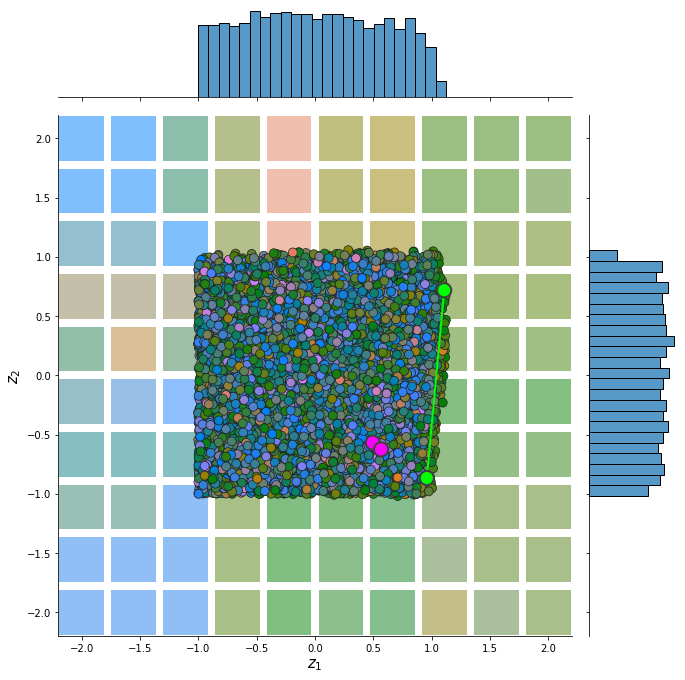

In [11]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [12]:
from pdmtut.vis import plot_reconstruction

In [13]:
z = model.encode(dataset.X)
x = model.decode(z)

0.9005435705184937 0.0
0.9004554748535156 0.0
0.9003675580024719 0.0
0.900279700756073 2.84217087951293e-21
0.9001919031143188 1.8699282302702545e-18
0.9001039266586304 7.190948140764487e-18
0.9000158905982971 1.5965902645104226e-17
0.8999281525611877 2.819479025251148e-17
0.899840235710144 4.478319191175695e-17
0.8997523188591003 8.465859090145412e-17
0.8996646404266357 1.883233846644572e-16
0.8995768427848816 3.616846752652059e-16
0.8994893431663513 6.052607720574699e-16
0.8994022607803345 9.229012692957285e-16
0.8993158340454102 1.3167145151982141e-15
0.8992297053337097 1.7870228907757026e-15
0.8991439342498779 2.3343654786955883e-15
0.8990584015846252 2.9591495920300306e-15
0.8989729285240173 3.661938252630393e-15
0.8988875150680542 4.442504697443895e-15
0.8988021612167358 5.3010851264190255e-15
0.8987168073654175 6.237956817756185e-15
0.8986310362815857 7.253779799043514e-15
0.8985453248023987 8.349466118495742e-15
0.8984593749046326 9.525273902966092e-15
0.8983728289604187 1.0791

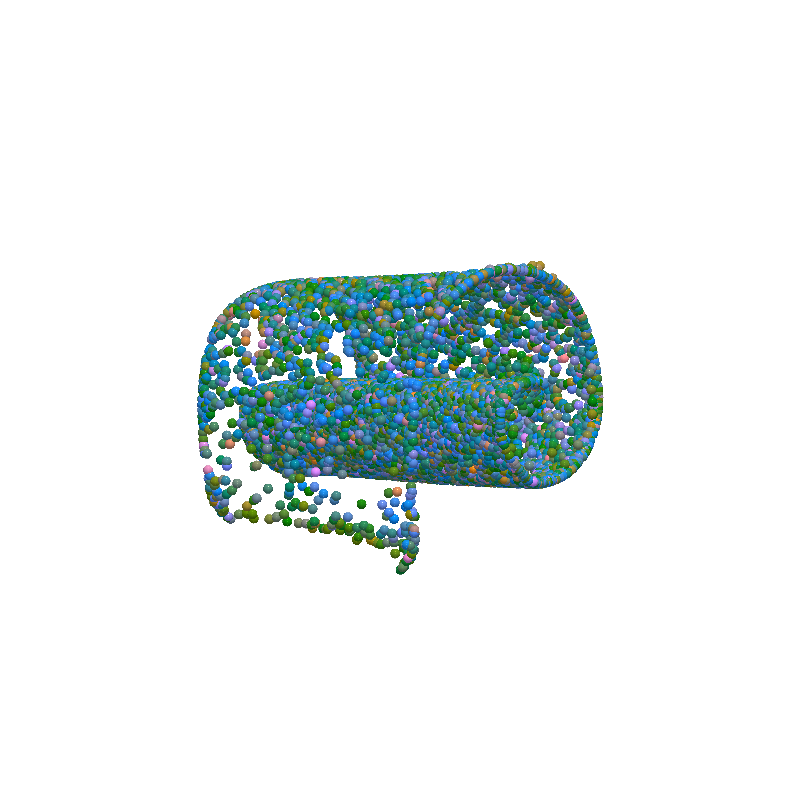

In [14]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [24]:
from pdmtut.vis import plot_density

In [25]:
log_likelihood = model.log_likelihood(dataset.X)

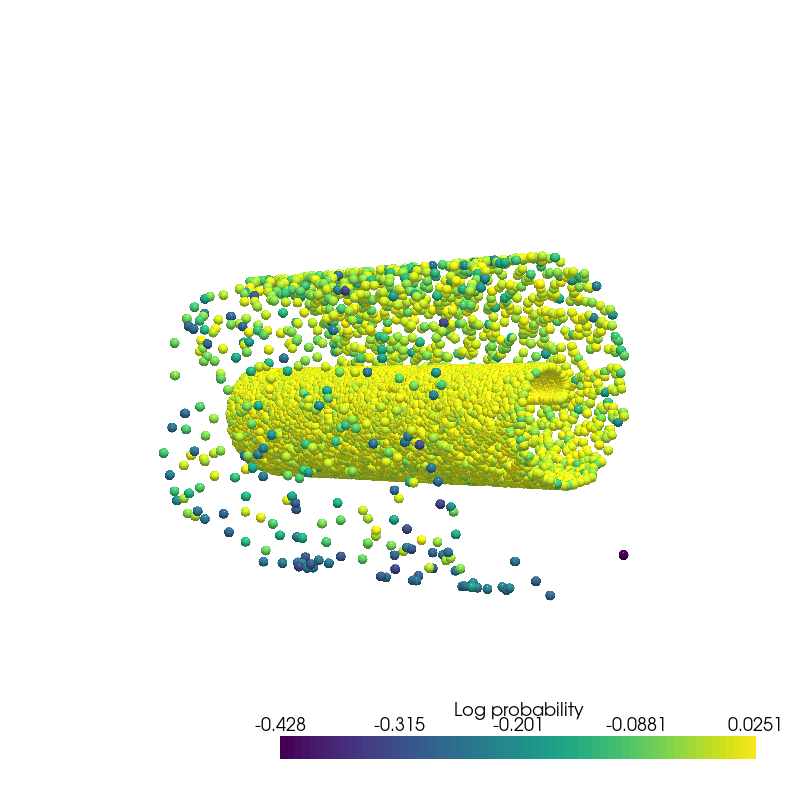

In [26]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

### Generate Samples

In [27]:
from pdmtut.vis import plot_generated_samples

In [28]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

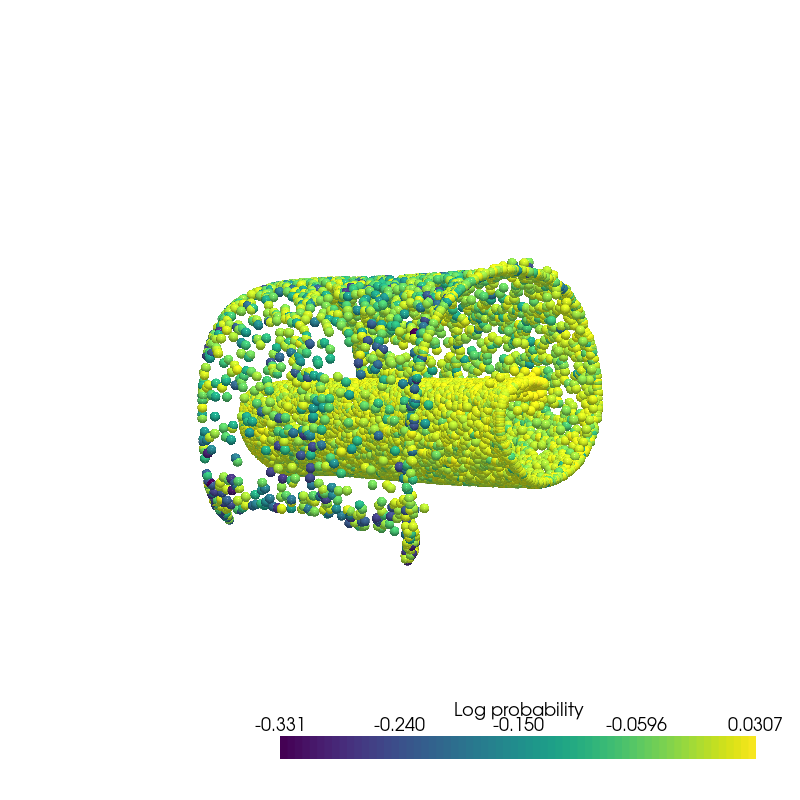

In [29]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

### Interpolation

In [33]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [34]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))

1.1116975545883179 0.0
0.8365138173103333 0.0
0.760339081287384 0.0
0.7021637558937073 0.0
0.6581897735595703 0.0
0.621963620185852 0.0
0.5909962058067322 0.0
0.5640350580215454 0.0
0.5404766798019409 0.0
0.5197005271911621 0.0
0.5012403130531311 0.0
0.4847536087036133 0.0
0.46996840834617615 0.0
0.45666393637657166 0.0
0.4446597993373871 0.0
0.43380671739578247 0.0
0.4239860773086548 0.0
0.41511592268943787 0.0
0.40709608793258667 0.0
0.39985430240631104 0.0
0.39338696002960205 0.0
0.3876115083694458 0.0
0.3824474513530731 0.0
0.37785604596138 0.0
0.37383753061294556 0.0
0.370336651802063 0.0
0.3672819435596466 0.0
0.364621102809906 0.0
0.36232322454452515 0.0
0.36033231019973755 0.0
0.35860106348991394 0.0
0.35709109902381897 0.0
0.3557666540145874 0.0
0.3545941114425659 0.0
0.35355058312416077 0.0
0.35261738300323486 0.0
0.35177820920944214 0.0
0.35101935267448425 0.0
0.3503289818763733 0.0
0.3496971130371094 0.0
0.3491150140762329 0.0
0.3485758304595947 1.9573144527385014e-12
0.348

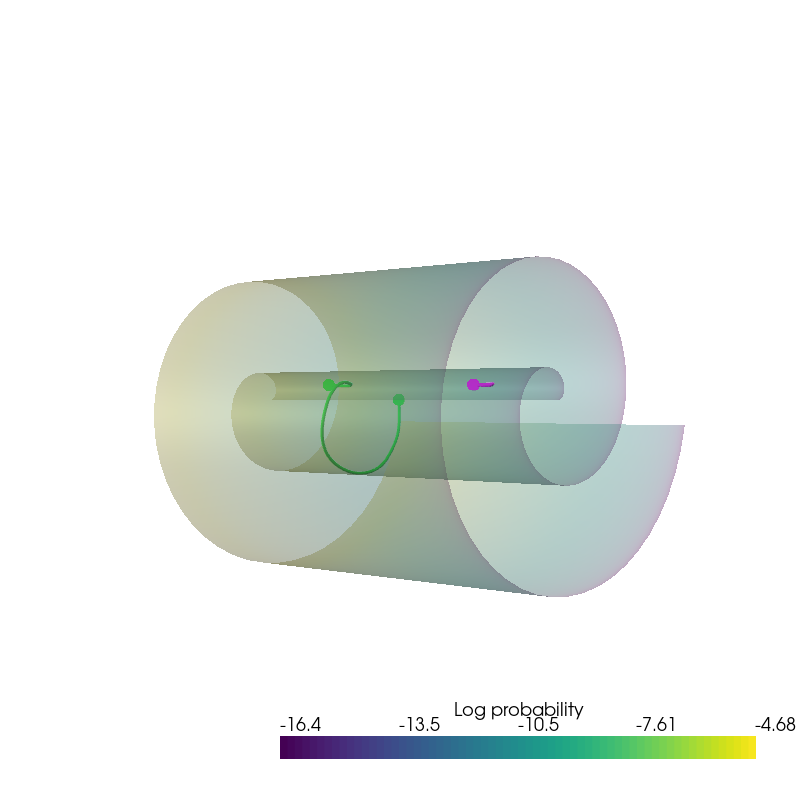

In [35]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)